# Курсовой проект

Датасет — **Aerial Semantic Segmentation (Aeroscapes)** 

https://www.kaggle.com/datasets/kooaslansefat/uav-segmentation-aeroscapes

In [ ]:
!pip install -q -U segmentation_models_pytorch

## Классы датасета
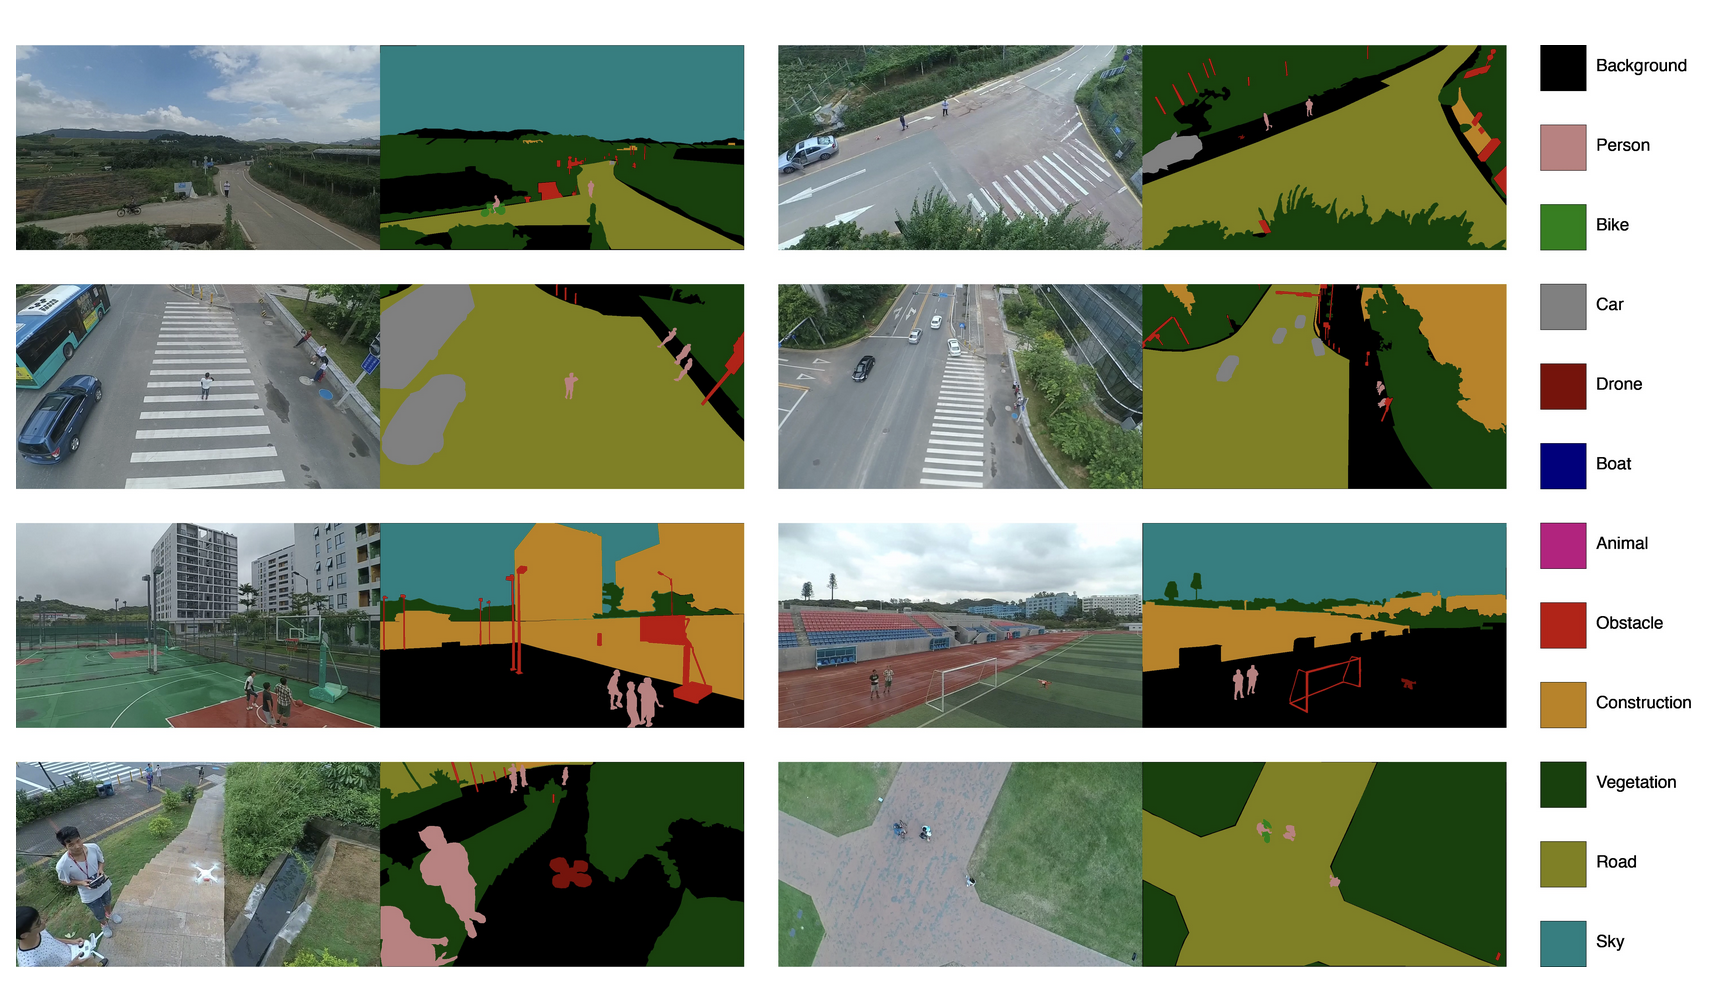

## Распределение классов


Number of masks: 3269


100%|██████████| 3269/3269 [55:59<00:00,  1.03s/it]


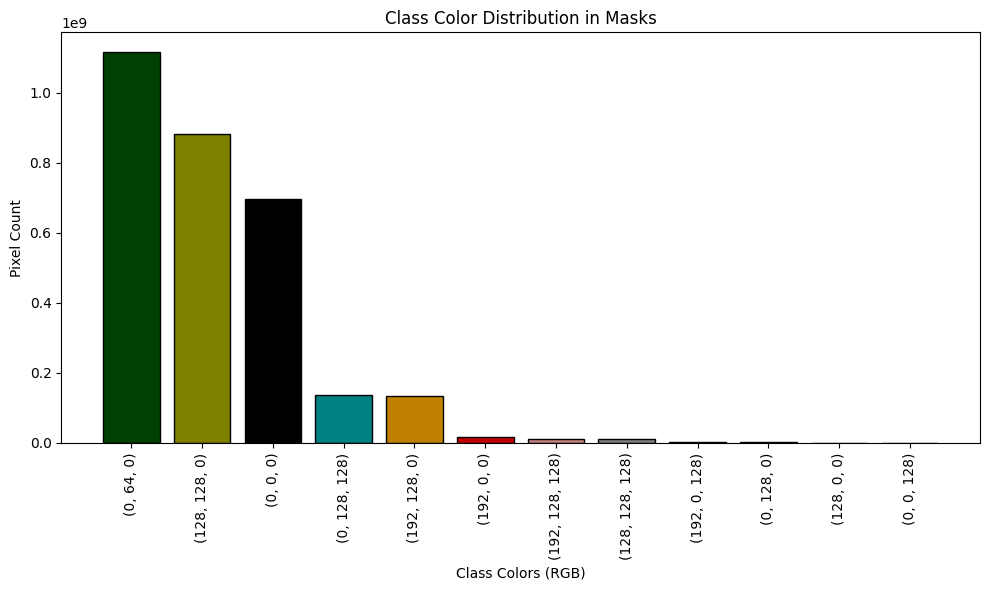

Colors and their pixel counts in the dataset:
Color (0, 64, 0): 1117021451 pixels
Color (128, 128, 0): 881708346 pixels
Color (0, 0, 0): 696388200 pixels
Color (0, 128, 128): 137855496 pixels
Color (192, 128, 0): 133909912 pixels
Color (192, 0, 0): 16946045 pixels
Color (192, 128, 128): 12114423 pixels
Color (128, 128, 128): 11114500 pixels
Color (192, 0, 128): 2524067 pixels
Color (0, 128, 0): 1596917 pixels
Color (128, 0, 0): 877424 pixels
Color (0, 0, 128): 653619 pixels


In [21]:
from tqdm import tqdm
from PIL import Image
import os
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np

dataset_path = '/home/jovyan/uav-segmentation-aeroscapes/aeroscapes/'
masks_path = os.path.join(dataset_path, 'Visualizations')

valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp')
mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(valid_extensions)]

num_masks = len(mask_files)
print(f"Number of masks: {num_masks}")

color_counts = Counter()
for mask_file in tqdm(mask_files):
    mask_path = os.path.join(masks_path, mask_file)
    mask = Image.open(mask_path).convert('RGB')
    colors = np.array(mask).reshape(-1, 3)  # фуфуфу так делать
    unique_colors, counts = np.unique(colors, axis=0, return_counts=True)
    for color, count in zip(unique_colors, counts):
        color_counts[tuple(color)] += count

sorted_colors = sorted(color_counts.items(), key=lambda x: x[1], reverse=True)

colors = [item[0] for item in sorted_colors]
counts = [item[1] for item in sorted_colors]

normalized_colors = [tuple(c / 255 for c in color) for color in colors]

plt.figure(figsize=(10, 6))
plt.bar(range(len(colors)), counts, color=normalized_colors, edgecolor='black')
plt.xticks(range(len(colors)), [str(c) for c in colors], rotation=90)
plt.title("Class Color Distribution in Masks")
plt.xlabel("Class Colors (RGB)")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()

print("Colors and their pixel counts in the dataset:")
for color, count in sorted_colors:
    print(f"Color {color}: {count} pixels")

## Загружаем данные

In [23]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, data = "trn", transformations = None):

        files = open(f"{root}/ImageSets/{data}.txt", "r").read().split("\n")
        self.im_paths, self.gt_paths = self.get_data_paths(root = root, files = files) 
        self.transformations = transformations
        self.n_cls = 11
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def get_data_paths(self, root, files): return [path for path in sorted(glob(f"{root}/JPEGImages/*.jpg")) if self.get_fname(path) in files], [path for path in sorted(glob(f"{root}/Visualizations/*.png")) if self.get_fname(path) in files]

    def get_fname(self, path): return os.path.splitext(os.path.basename(path))[0]

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]
    
def get_dls(root, transformations, bs, split = [0.9, 0.1], ns = 8):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, data = "trn", transformations = transformations)
    ts_ds = CustomSegmentationDataset(root = root, data = "val", transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0]); val_len = len(ds) - tr_len
    
    # Data split
    tr_ds, val_ds = torch.utils.data.random_split(ds, [tr_len, val_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(ts_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, test_dl, n_cls


mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = dataset_path, transformations = trans, bs = 8)


There are 2358 number of images in the train set
There are 263 number of images in the validation set
There are 648 number of images in the test set



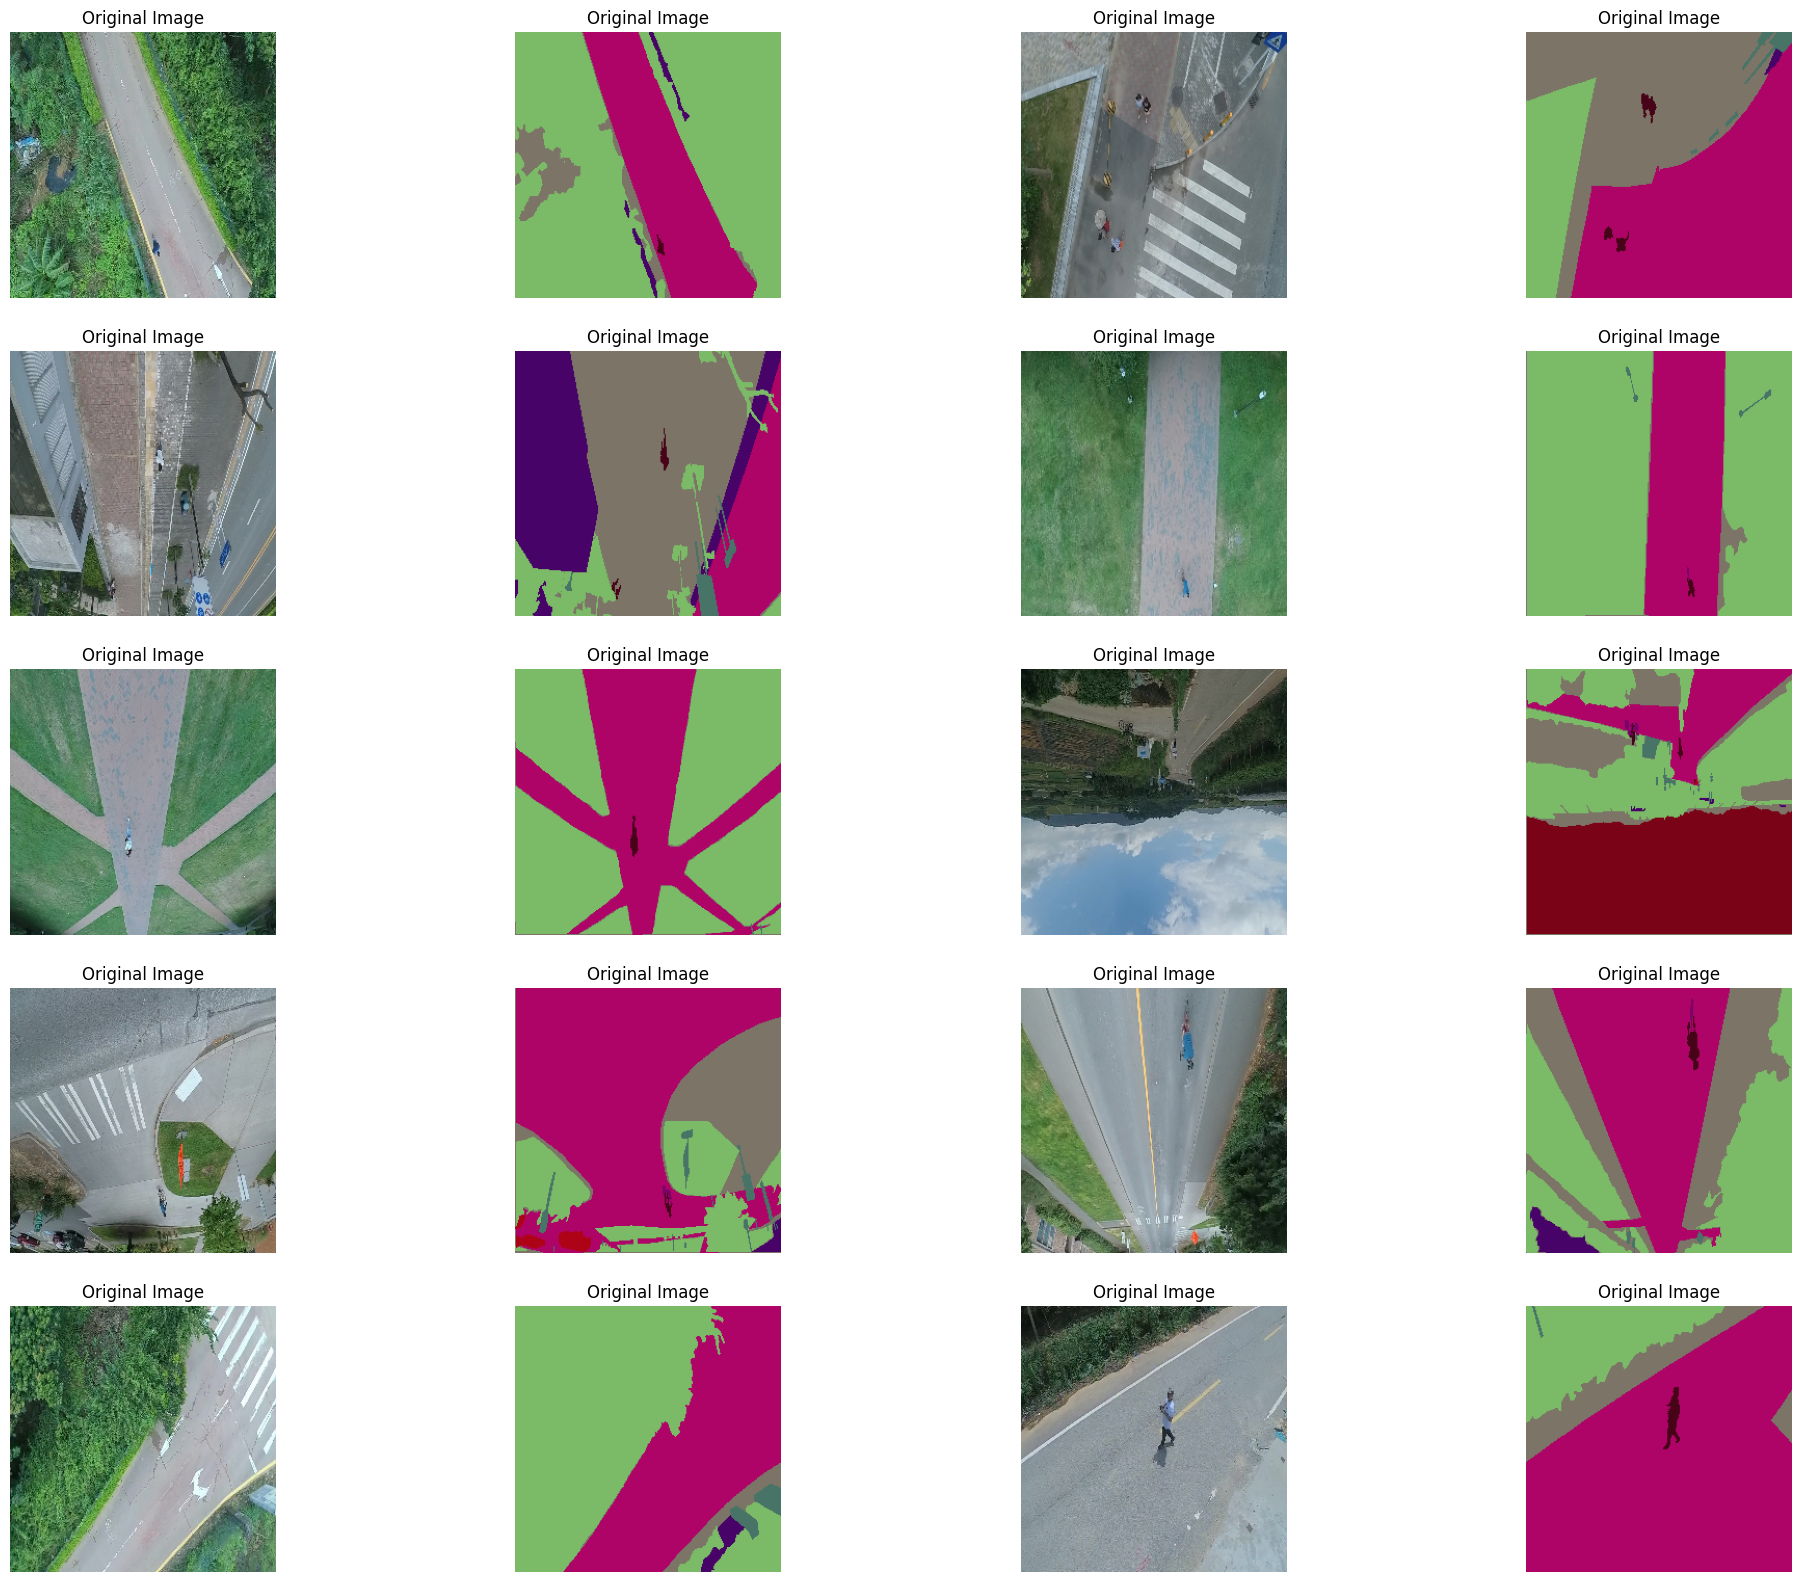

In [24]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)
        
visualize(tr_dl.dataset, n_ims = 20)

## Готовим к обучению

In [26]:
import ssl
import urllib3
import segmentation_models_pytorch as smp
import time
from tqdm import tqdm
from torch.nn import functional as F
ssl._create_default_https_context = ssl._create_unverified_context
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

encoder, weight = 'dpn107', 'imagenet+5k' 
model = smp.DeepLabV3Plus(encoder_name=encoder, encoder_weights=weight, classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 2.5e-5)

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

## Обучаем

In [27]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):

            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            not_improve = 0
            print("Saving the model with the best loss value...")
            torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1

            print(f"Loss did not decrease for {not_improve} epoch(s)!")

            if not_improve == early_stop_threshold:

                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break

        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = f"aerospaces_{encoder}_{weight}")

Start training process...
Epoch 1 train process is started...


100%|██████████| 295/295 [00:28<00:00, 10.21it/s]


Epoch 1 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.79it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 30.998 secs
Train Loss         -> 1.059
Train PA           -> 0.846
Train IoU          -> 0.754
Validation Loss    -> 0.478
Validation PA      -> 0.948
Validation IoU     -> 0.861

Loss decreased from inf to 0.478!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.68it/s]


Epoch 2 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.73it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 29.735 secs
Train Loss         -> 0.376
Train PA           -> 0.951
Train IoU          -> 0.862
Validation Loss    -> 0.249
Validation PA      -> 0.962
Validation IoU     -> 0.886

Loss decreased from 0.478 to 0.249!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.69it/s]


Epoch 3 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.33it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 29.757 secs
Train Loss         -> 0.229
Train PA           -> 0.962
Train IoU          -> 0.877
Validation Loss    -> 0.158
Validation PA      -> 0.968
Validation IoU     -> 0.897

Loss decreased from 0.249 to 0.158!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.60it/s]


Epoch 4 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.58it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 30.100 secs
Train Loss         -> 0.170
Train PA           -> 0.966
Train IoU          -> 0.886
Validation Loss    -> 0.137
Validation PA      -> 0.968
Validation IoU     -> 0.896

Loss decreased from 0.158 to 0.137!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.68it/s]


Epoch 5 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 29.914 secs
Train Loss         -> 0.127
Train PA           -> 0.970
Train IoU          -> 0.892
Validation Loss    -> 0.109
Validation PA      -> 0.972
Validation IoU     -> 0.904

Loss decreased from 0.137 to 0.109!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.64it/s]


Epoch 6 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 16.03it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 29.803 secs
Train Loss         -> 0.109
Train PA           -> 0.973
Train IoU          -> 0.898
Validation Loss    -> 0.095
Validation PA      -> 0.973
Validation IoU     -> 0.906

Loss decreased from 0.109 to 0.095!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.66it/s]


Epoch 7 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.72it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 29.912 secs
Train Loss         -> 0.092
Train PA           -> 0.974
Train IoU          -> 0.902
Validation Loss    -> 0.083
Validation PA      -> 0.974
Validation IoU     -> 0.909

Loss decreased from 0.095 to 0.083!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.56it/s]


Epoch 8 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.97it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 30.018 secs
Train Loss         -> 0.085
Train PA           -> 0.975
Train IoU          -> 0.903
Validation Loss    -> 0.079
Validation PA      -> 0.974
Validation IoU     -> 0.909

Loss decreased from 0.083 to 0.079!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.58it/s]


Epoch 9 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.16it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 30.223 secs
Train Loss         -> 0.075
Train PA           -> 0.976
Train IoU          -> 0.904
Validation Loss    -> 0.076
Validation PA      -> 0.974
Validation IoU     -> 0.909

Loss decreased from 0.079 to 0.076!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.61it/s]


Epoch 10 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.97it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 30.018 secs
Train Loss         -> 0.071
Train PA           -> 0.977
Train IoU          -> 0.906
Validation Loss    -> 0.071
Validation PA      -> 0.975
Validation IoU     -> 0.915

Loss decreased from 0.076 to 0.071!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.70it/s]


Epoch 11 validation process is started...


100%|██████████| 33/33 [00:01<00:00, 17.35it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 29.491 secs
Train Loss         -> 0.068
Train PA           -> 0.977
Train IoU          -> 0.908
Validation Loss    -> 0.067
Validation PA      -> 0.976
Validation IoU     -> 0.922

Loss decreased from 0.071 to 0.067!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.62it/s]


Epoch 12 validation process is started...


100%|██████████| 33/33 [00:01<00:00, 16.86it/s]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 29.751 secs
Train Loss         -> 0.064
Train PA           -> 0.978
Train IoU          -> 0.911
Validation Loss    -> 0.064
Validation PA      -> 0.976
Validation IoU     -> 0.924

Loss decreased from 0.067 to 0.064!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.63it/s]


Epoch 13 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.55it/s]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 29.891 secs
Train Loss         -> 0.060
Train PA           -> 0.979
Train IoU          -> 0.917
Validation Loss    -> 0.063
Validation PA      -> 0.976
Validation IoU     -> 0.928

Loss decreased from 0.064 to 0.063!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.62it/s]


Epoch 14 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.85it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 29.870 secs
Train Loss         -> 0.056
Train PA           -> 0.979
Train IoU          -> 0.918
Validation Loss    -> 0.060
Validation PA      -> 0.977
Validation IoU     -> 0.925

Loss decreased from 0.063 to 0.060!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████| 295/295 [00:28<00:00, 10.44it/s]


Epoch 15 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 13.98it/s]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 30.626 secs
Train Loss         -> 0.055
Train PA           -> 0.980
Train IoU          -> 0.920
Validation Loss    -> 0.063
Validation PA      -> 0.976
Validation IoU     -> 0.930

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.68it/s]


Epoch 16 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.05it/s]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 29.808 secs
Train Loss         -> 0.055
Train PA           -> 0.980
Train IoU          -> 0.924
Validation Loss    -> 0.061
Validation PA      -> 0.977
Validation IoU     -> 0.931

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.64it/s]


Epoch 17 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.97it/s]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 29.928 secs
Train Loss         -> 0.051
Train PA           -> 0.981
Train IoU          -> 0.923
Validation Loss    -> 0.058
Validation PA      -> 0.977
Validation IoU     -> 0.935

Loss decreased from 0.060 to 0.058!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.54it/s]


Epoch 18 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.69it/s]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 30.243 secs
Train Loss         -> 0.061
Train PA           -> 0.978
Train IoU          -> 0.917
Validation Loss    -> 0.057
Validation PA      -> 0.977
Validation IoU     -> 0.928

Loss decreased from 0.058 to 0.057!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.60it/s]


Epoch 19 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.84it/s]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 29.911 secs
Train Loss         -> 0.051
Train PA           -> 0.980
Train IoU          -> 0.925
Validation Loss    -> 0.055
Validation PA      -> 0.978
Validation IoU     -> 0.935

Loss decreased from 0.057 to 0.055!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.71it/s]


Epoch 20 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.05it/s]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 29.743 secs
Train Loss         -> 0.048
Train PA           -> 0.981
Train IoU          -> 0.931
Validation Loss    -> 0.055
Validation PA      -> 0.978
Validation IoU     -> 0.937

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.72it/s]


Epoch 21 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.47it/s]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 29.669 secs
Train Loss         -> 0.047
Train PA           -> 0.981
Train IoU          -> 0.931
Validation Loss    -> 0.057
Validation PA      -> 0.977
Validation IoU     -> 0.932

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.68it/s]


Epoch 22 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.42it/s]


Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 29.779 secs
Train Loss         -> 0.046
Train PA           -> 0.982
Train IoU          -> 0.935
Validation Loss    -> 0.054
Validation PA      -> 0.978
Validation IoU     -> 0.931

Loss decreased from 0.055 to 0.054!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process is started...


100%|██████████| 295/295 [00:28<00:00, 10.53it/s]


Epoch 23 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.10it/s]


Epoch 23 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process results: 

Train Time         -> 30.361 secs
Train Loss         -> 0.045
Train PA           -> 0.982
Train IoU          -> 0.932
Validation Loss    -> 0.054
Validation PA      -> 0.978
Validation IoU     -> 0.938

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.69it/s]


Epoch 24 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.97it/s]


Epoch 24 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process results: 

Train Time         -> 29.669 secs
Train Loss         -> 0.044
Train PA           -> 0.982
Train IoU          -> 0.935
Validation Loss    -> 0.052
Validation PA      -> 0.979
Validation IoU     -> 0.932

Loss decreased from 0.054 to 0.052!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.65it/s]


Epoch 25 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.66it/s]


Epoch 25 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process results: 

Train Time         -> 29.947 secs
Train Loss         -> 0.044
Train PA           -> 0.982
Train IoU          -> 0.935
Validation Loss    -> 0.051
Validation PA      -> 0.979
Validation IoU     -> 0.939

Loss decreased from 0.052 to 0.051!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.66it/s]


Epoch 26 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.96it/s]


Epoch 26 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process results: 

Train Time         -> 29.896 secs
Train Loss         -> 0.042
Train PA           -> 0.983
Train IoU          -> 0.935
Validation Loss    -> 0.050
Validation PA      -> 0.979
Validation IoU     -> 0.941

Loss decreased from 0.051 to 0.050!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.61it/s]


Epoch 27 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.86it/s]


Epoch 27 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process results: 

Train Time         -> 30.027 secs
Train Loss         -> 0.042
Train PA           -> 0.983
Train IoU          -> 0.935
Validation Loss    -> 0.050
Validation PA      -> 0.979
Validation IoU     -> 0.941

Loss decreased from 0.050 to 0.050!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.62it/s]


Epoch 28 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.14it/s]


Epoch 28 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process results: 

Train Time         -> 30.107 secs
Train Loss         -> 0.041
Train PA           -> 0.983
Train IoU          -> 0.936
Validation Loss    -> 0.050
Validation PA      -> 0.979
Validation IoU     -> 0.940

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.67it/s]


Epoch 29 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.41it/s]


Epoch 29 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 train process results: 

Train Time         -> 29.789 secs
Train Loss         -> 0.040
Train PA           -> 0.983
Train IoU          -> 0.941
Validation Loss    -> 0.050
Validation PA      -> 0.979
Validation IoU     -> 0.940

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.57it/s]


Epoch 30 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 16.41it/s]


Epoch 30 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 train process results: 

Train Time         -> 29.939 secs
Train Loss         -> 0.039
Train PA           -> 0.984
Train IoU          -> 0.941
Validation Loss    -> 0.052
Validation PA      -> 0.979
Validation IoU     -> 0.934

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.72it/s]


Epoch 31 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.59it/s]


Epoch 31 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 train process results: 

Train Time         -> 29.788 secs
Train Loss         -> 0.039
Train PA           -> 0.984
Train IoU          -> 0.939
Validation Loss    -> 0.049
Validation PA      -> 0.980
Validation IoU     -> 0.944

Loss decreased from 0.050 to 0.049!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.63it/s]


Epoch 32 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


Epoch 32 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 train process results: 

Train Time         -> 30.035 secs
Train Loss         -> 0.038
Train PA           -> 0.984
Train IoU          -> 0.942
Validation Loss    -> 0.049
Validation PA      -> 0.980
Validation IoU     -> 0.937

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.64it/s]


Epoch 33 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.74it/s]


Epoch 33 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 train process results: 

Train Time         -> 29.821 secs
Train Loss         -> 0.038
Train PA           -> 0.984
Train IoU          -> 0.941
Validation Loss    -> 0.048
Validation PA      -> 0.980
Validation IoU     -> 0.943

Loss decreased from 0.049 to 0.048!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.61it/s]


Epoch 34 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.74it/s]


Epoch 34 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 train process results: 

Train Time         -> 29.913 secs
Train Loss         -> 0.038
Train PA           -> 0.984
Train IoU          -> 0.943
Validation Loss    -> 0.050
Validation PA      -> 0.980
Validation IoU     -> 0.945

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.69it/s]


Epoch 35 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.29it/s]


Epoch 35 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 train process results: 

Train Time         -> 29.765 secs
Train Loss         -> 0.037
Train PA           -> 0.984
Train IoU          -> 0.944
Validation Loss    -> 0.049
Validation PA      -> 0.980
Validation IoU     -> 0.942

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.71it/s]


Epoch 36 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 16.08it/s]


Epoch 36 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 train process results: 

Train Time         -> 29.599 secs
Train Loss         -> 0.052
Train PA           -> 0.980
Train IoU          -> 0.930
Validation Loss    -> 0.052
Validation PA      -> 0.979
Validation IoU     -> 0.941

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.71it/s]


Epoch 37 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.52it/s]


Epoch 37 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 train process results: 

Train Time         -> 29.815 secs
Train Loss         -> 0.039
Train PA           -> 0.984
Train IoU          -> 0.939
Validation Loss    -> 0.048
Validation PA      -> 0.980
Validation IoU     -> 0.943

Loss decreased from 0.048 to 0.048!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.62it/s]


Epoch 38 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.87it/s]


Epoch 38 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 train process results: 

Train Time         -> 29.875 secs
Train Loss         -> 0.037
Train PA           -> 0.984
Train IoU          -> 0.943
Validation Loss    -> 0.049
Validation PA      -> 0.980
Validation IoU     -> 0.942

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.63it/s]


Epoch 39 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 16.26it/s]


Epoch 39 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 train process results: 

Train Time         -> 29.783 secs
Train Loss         -> 0.036
Train PA           -> 0.985
Train IoU          -> 0.944
Validation Loss    -> 0.048
Validation PA      -> 0.980
Validation IoU     -> 0.942

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.68it/s]


Epoch 40 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.32it/s]


Epoch 40 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 train process results: 

Train Time         -> 29.793 secs
Train Loss         -> 0.036
Train PA           -> 0.985
Train IoU          -> 0.944
Validation Loss    -> 0.048
Validation PA      -> 0.981
Validation IoU     -> 0.945

Loss decreased from 0.048 to 0.048!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.62it/s]


Epoch 41 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.50it/s]


Epoch 41 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 train process results: 

Train Time         -> 29.925 secs
Train Loss         -> 0.035
Train PA           -> 0.985
Train IoU          -> 0.943
Validation Loss    -> 0.047
Validation PA      -> 0.981
Validation IoU     -> 0.947

Loss decreased from 0.048 to 0.047!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.67it/s]


Epoch 42 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 16.08it/s]


Epoch 42 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 train process results: 

Train Time         -> 29.705 secs
Train Loss         -> 0.035
Train PA           -> 0.985
Train IoU          -> 0.948
Validation Loss    -> 0.048
Validation PA      -> 0.980
Validation IoU     -> 0.944

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.65it/s]


Epoch 43 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.35it/s]


Epoch 43 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 train process results: 

Train Time         -> 30.002 secs
Train Loss         -> 0.034
Train PA           -> 0.986
Train IoU          -> 0.947
Validation Loss    -> 0.047
Validation PA      -> 0.981
Validation IoU     -> 0.945

Loss decreased from 0.047 to 0.047!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.68it/s]


Epoch 44 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.78it/s]


Epoch 44 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 train process results: 

Train Time         -> 29.719 secs
Train Loss         -> 0.034
Train PA           -> 0.986
Train IoU          -> 0.948
Validation Loss    -> 0.046
Validation PA      -> 0.981
Validation IoU     -> 0.947

Loss decreased from 0.047 to 0.046!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.64it/s]


Epoch 45 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.46it/s]


Epoch 45 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 train process results: 

Train Time         -> 30.011 secs
Train Loss         -> 0.033
Train PA           -> 0.986
Train IoU          -> 0.946
Validation Loss    -> 0.047
Validation PA      -> 0.981
Validation IoU     -> 0.946

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.64it/s]


Epoch 46 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.41it/s]


Epoch 46 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 train process results: 

Train Time         -> 29.885 secs
Train Loss         -> 0.033
Train PA           -> 0.986
Train IoU          -> 0.949
Validation Loss    -> 0.047
Validation PA      -> 0.981
Validation IoU     -> 0.946

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.64it/s]


Epoch 47 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.23it/s]


Epoch 47 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 train process results: 

Train Time         -> 29.889 secs
Train Loss         -> 0.033
Train PA           -> 0.986
Train IoU          -> 0.948
Validation Loss    -> 0.047
Validation PA      -> 0.981
Validation IoU     -> 0.947

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.63it/s]


Epoch 48 validation process is started...


100%|██████████| 33/33 [00:01<00:00, 16.81it/s]


Epoch 48 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 train process results: 

Train Time         -> 29.731 secs
Train Loss         -> 0.032
Train PA           -> 0.986
Train IoU          -> 0.951
Validation Loss    -> 0.046
Validation PA      -> 0.981
Validation IoU     -> 0.948

Loss decreased from 0.046 to 0.046!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.69it/s]


Epoch 49 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.58it/s]


Epoch 49 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 train process results: 

Train Time         -> 29.731 secs
Train Loss         -> 0.032
Train PA           -> 0.986
Train IoU          -> 0.954
Validation Loss    -> 0.046
Validation PA      -> 0.981
Validation IoU     -> 0.948

Loss decreased from 0.046 to 0.046!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 train process is started...


100%|██████████| 295/295 [00:27<00:00, 10.60it/s]


Epoch 50 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 16.09it/s]

Epoch 50 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 train process results: 

Train Time         -> 29.884 secs
Train Loss         -> 0.032
Train PA           -> 0.987
Train IoU          -> 0.950
Validation Loss    -> 0.047
Validation PA      -> 0.982
Validation IoU     -> 0.947

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 25.371 minutes.


## Метрики

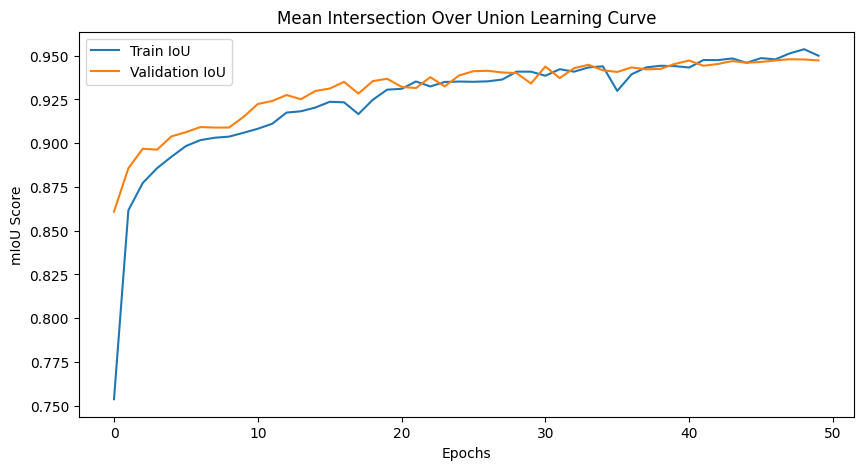

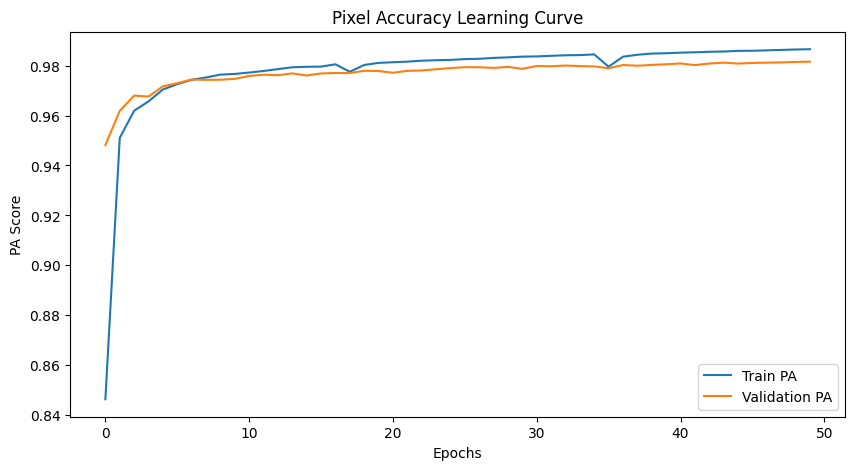

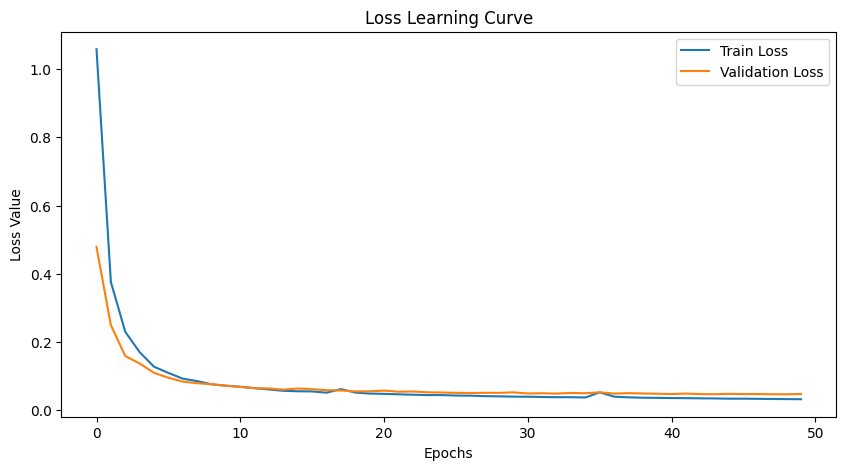

In [28]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU", 
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")
    
        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA", 
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")
        
        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss", 
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        
        
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)
    
    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)                
        
Plot(history)

## Пример инференса

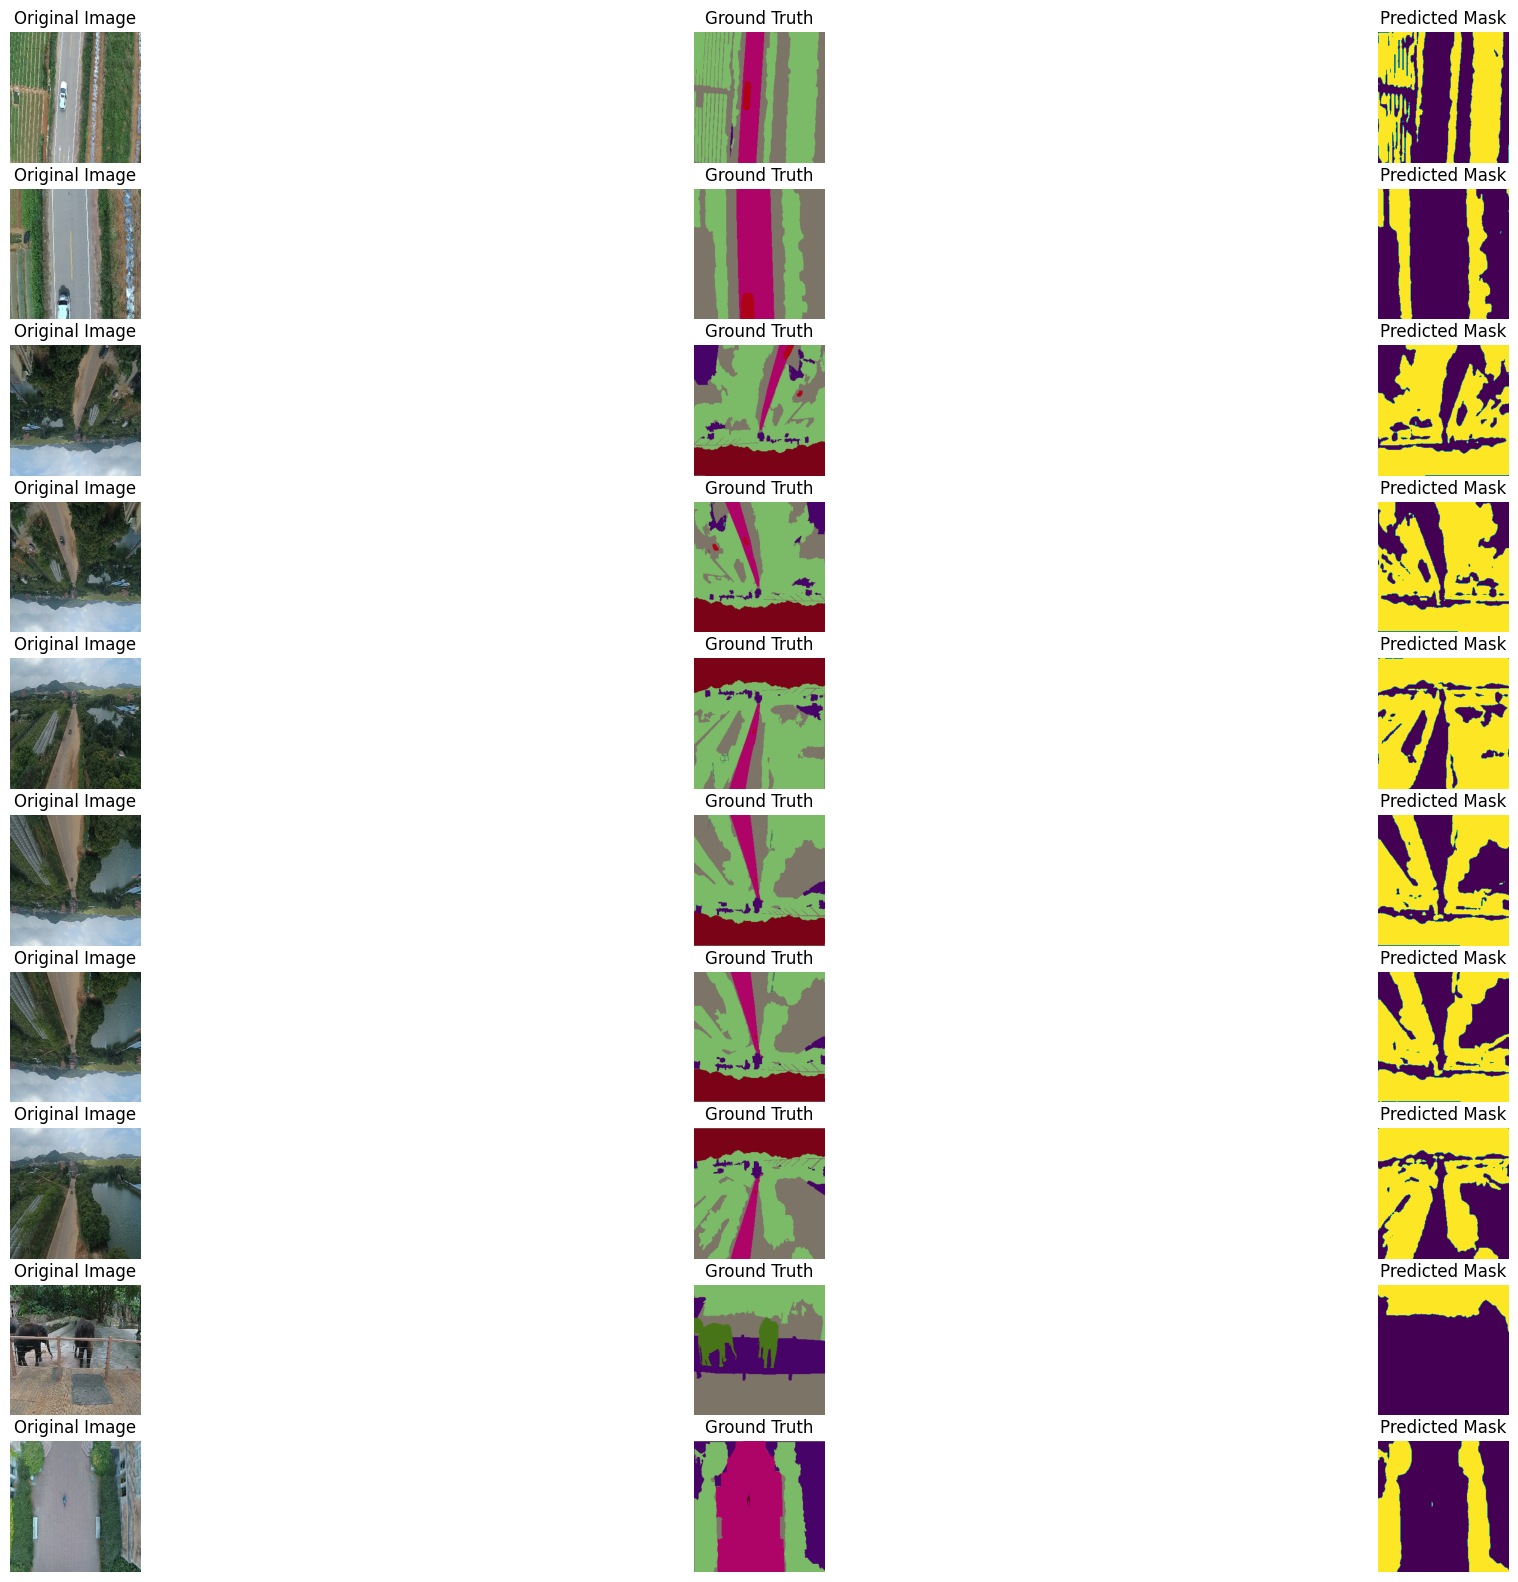

In [29]:
def inference(dl, model, device, n_ims = 30):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    indices = [random.randint(0, len(dl.dataset) - 1) for _ in range(n_ims)]
    
    for idx, data in enumerate(dl):
        
        if idx not in indices: continue
        else:
            im, gt = data
            # Get predicted mask
            with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
            ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")
        
model = torch.load(f"saved_models/aerospaces_{encoder}_{weight}_best_model.pt")
inference(dl = test_dl, model = model, device = device)

## Пример ML System Design для автономной навигации беспилотника по спутниковым снимкам

Этот датасет состоит из сегментированных изображений, сделанных с дронов, где каждый пиксель на изображении относится к одному из классов (например, дороги, деревья, здания, автомобили). Датасет подходит для задач семантической сегментации, выделения объектов и их контекстного анализа в сценах, снятых с воздуха.

### Компоненты системы

1. Сбор данных
	-	Датасеты:
    	-	UAV Segmentation Aeroscapes: Для обучения модели сегментации объектов.
    	-	Спутниковые снимки (например, Google Earth, OpenStreetMap): Для дополнения тренировочных данных.
	-	Обогащение данных:
    	-	Использовать аугментацию (вращение, шум, изменение яркости), чтобы адаптировать модель к условиям, встречающимся в реальной среде.

2. Предварительная обработка данных
	-	Приведение изображений к одному разрешению:
	-	Увеличение или уменьшение размеров изображений для единообразия.
	-	Создание масок для обучения:
    	-	Использование цветовых кодов, представляющих классы (например, дороги — [128, 64, 128], деревья — [0, 128, 0]).
    	-	Разделение на обучающую, валидационную и тестовую выборки.

3. Модель сегментации
	-	Архитектура:
    	-	Использовать DeepLabV3+, U-Net или SegFormer для сегментации сцены.
	-	Выход: Пиксельное разделение на классы (дороги, здания, деревья, препятствия и т. д.).
    -	Дополнения:
    	-	Предварительно обучить модель на AeroScapes, затем дообучить на спутниковых снимках.
    	-	Использовать подход Transfer Learning, чтобы минимизировать затраты на вычисления.

4. Планировщик маршрутов
	-	Вход:
    	-	Сегментированная карта с выделенными объектами (дороги, препятствия, водоемы, деревья и т. д.).
	-	Выход:
    	-	Оптимальный маршрут от точки A до точки B.
	-	Алгоритм:
    	-	Использовать A* или Dijkstra для поиска пути с учетом ограничений (например, избегание деревьев и зданий, использование дорог).
    	-	Постоянно обновлять карту на основе данных с камеры дрона.

5. Реальное время
	-	Задачи:
    	-	Обработка входящих изображений в реальном времени.
    	-	Постоянное обновление карты и сегментации.
	-	Реализация:
    	-	Использовать NVIDIA Jetson (например, Nano, Xavier) для ускорения обработки на борту дрона.

6. Система контроля
	-	Отслеживание безопасности полета:
	-	Проверка на столкновения с объектами.
	-	Использование данных LiDAR или стереокамер для дополнения данных сегментации.
	-	Реакция на динамические изменения:
	-	Перестроение маршрута при появлении новых препятствий (например, других дронов).

### Возможные применения
	1.	Навигация в труднодоступных местах
	2.	Мониторинг инфраструктуры
	3.	Аграрные технологии

### ML Pipeline
	1.	Подготовка данных (Aeroscapes + спутниковые изображения).
	2.	Обучение модели сегментации.
	3.	Развертывание модели.
	4.	Инференс
	5.	Сбор новых данных и дообучение модели.